# An analysis of Department of Health and Human Services Funding in California

## Rodrigo González Laiz & Katie Truong

In [25]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [137]:
import numpy as np
import pandas as pd

import bokeh
from bokeh.io import show
from bokeh.models import LogColorMapper, CustomJS, Toggle, ColumnDataSource, CDSView, GroupFilter
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from bokeh.layouts import column, row, widgetbox 

from bokeh.models.widgets import Slider
from bokeh.models import LogColorMapper, LogTicker, ColorBar
from bokeh.layouts import Column

from bokeh.sampledata.us_counties import data as counties


bokeh.io.output_notebook()

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from plotnine import *
pd.options.display.max_rows = 4000

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p9.options.figure_size = (10, 7.5)


Loading BokehJS ...

# Introduction and Motivation:

Among all agencies in the US, Department of Health and Human Services is the biggest spender (which takes up to 25.4% among of all the funding in 2018). In this project, we want to explore the funding of Department of Health and Human Services in California, one of the biggest states in the United States. Our project includes two parts:

**1. Analysis:**

In this section, we would go over the funding and awarding of Department of Health and Human Services (HHS) in California in from 2000 to 2018, analyze the trend and categories of spending over the years, the demographic features that may affect the spending, etc...

**2. Classification:**

We observe that around 30% of the spendings are missing the county that was awarded. We want to train a classifier that would fill out the locations that are missing based on other features in the dataset.

## 1. Analysis of Department of Health and Human Services awards in California:

First, we can look at the total obligation of each county for every year from 2000 to 2018 (we excluded 2019 because there are very few transactions).

In [27]:
def county_name_format(name):
    final_name = ""
    try:
        if type(name) != 'float':
            words = name.split(" ")
            if (words[-1] == 'COUNTY') or (words[-1] == '(COUNTY)'):
                words.pop()
            for i in range(0, len(words)):
                final_name += words[i].capitalize() + " "
            final_name = final_name.rstrip()
        else:
            final_name = np.nan
    except:
        pass
    return(final_name)

In [88]:
df = pd.read_csv("hhs_ca_adjusted.csv")
df['total_obligation'] = df['total_obligation'] / 1000000 #unit: 1 million dollars
df = df.sort_values(by=['fiscal_year'])
cols_to_drop = [0]
df.drop(df.columns[cols_to_drop],axis=1,inplace=True)
df = df.fillna(0)
# df['recipient_unique_id'] = df['recipient_unique_id'].apply(lambda x: int(x) if x == x else "")
df['recipient_location_county_name'] = df['recipient_location_county_name'].apply(lambda x: county_name_format(x) if x == x else "")
df = df[(df['recipient_location_county_name']!='')&(df['recipient_location_county_name']!=0)]
df = df[df['fiscal_year'] != 2019]

In [89]:
total = df.groupby(['fiscal_year', 'recipient_location_county_name'])['total_obligation'].sum().reset_index().sort_values(by=['fiscal_year','total_obligation'], ascending=False)

In [90]:
total_top_five = total.groupby('fiscal_year').head(5)

In [91]:
total_top_five['log_obligation'] = np.log(total_top_five['total_obligation'])

The funding/awarding amount of Department of Health and Human Services for each county in California differ greatly across the counties across the years, with a median of 306.87 million USD in 2008 (adjusted for inflation), and 1000.59 million USD in 2018. It also has a very large standard deviation, 14,696 million USD in 2008, and 124,283 USD in 2018, which signifies either a the difference in awarding/funding amount, or a difference in transaction documentating of each county, or both.

We can also notify a significant shift in funding/spending between 2006 and 2007, which may be attributed to documentation process, rather than the amount of actual spending.

In [153]:
total.groupby(['fiscal_year']).describe()

total_obligation                                         \
                       count          mean            std       min   
fiscal_year                                                           
2001                    51.0     30.110566      90.070688 -8.732827   
2002                    51.0     61.381507     149.546792 -0.329849   
2003                    50.0     86.810035     273.295602 -0.573563   
2004                    52.0     60.920011     157.022150  0.003053   
2005                    52.0     83.049373     202.445072  0.011134   
2006                    50.0     81.061963     202.044947 -0.001641   
2007                    55.0   2669.327793   14533.383108 -0.283545   
2008                    58.0   3035.629417   14696.858281  1.130387   
2009                    58.0   5875.304910   27946.243624  6.558586   
2010                    58.0   5996.076537   34212.064116  1.912004   
2011                    55.0  11054.679078   69038.671175  0.082385   
2012                    55.0   8123.553297   47559.265832  3.032468   
2013                    56.0   7344.434619   40427.707832  0.643691   
2014                    57.0   9471.939470   56682.528838  0.652849   
2015                    56.0   8949.051705   51713.262986  0.008963   
2016                    57.0   8001.677480   44933.959042  0.047187   
2017                    55.0   8052.016377   39677.245666  0.048388   
2018                    57.0  19973.520850  124283.374950  0.010000   

                                                                  
                    25%          50%          75%            max  
fiscal_year                                                       
2001          -0.025125     0.729667     7.962008     503.497755  
2002           1.601719     7.720636    23.817855     655.433938  
2003           0.507849     1.572833    20.086102    1657.925042  
2004           0.826475     2.154826    15.764479     691.472421  
2005           1.370206     4.893163    22.809267     914.886943  
2006           1.240621     3.977020    22.868972     903.079960  
2007          35.632459   159.243634   587.957548  107808.479921  
2008          87.325737   306.878409   889.755458  110977.431527  
2009         167.985357   702.914049  1860.749853  211504.420572  
2010          83.920397   327.577209  1254.166693  260652.871688  
2011          76.437352   529.816745  1751.600945  512969.878969  
2012         139.118863   457.529994  1384.005596  353063.695807  
2013         139.372404   518.312952  1632.539380  302381.642056  
2014         123.674083   611.448284  1349.092686  428248.240920  
2015         107.632370   474.458168  1359.899642  386857.130935  
2016          65.437927   521.602098  1359.791008  338488.359478  
2017         115.372463   678.709963  1590.390307  291972.231708  
2018         180.797175  1059.408483  2727.983194  939267.671103

Sacramento, Los Angeles, San Diego, San Francisco, Alameda, Santa Clara, Yolo, etc... are the counties that frequently appear in the top five spending counties of every year, whith Sacramento (the capitol of California) being the top of every year.

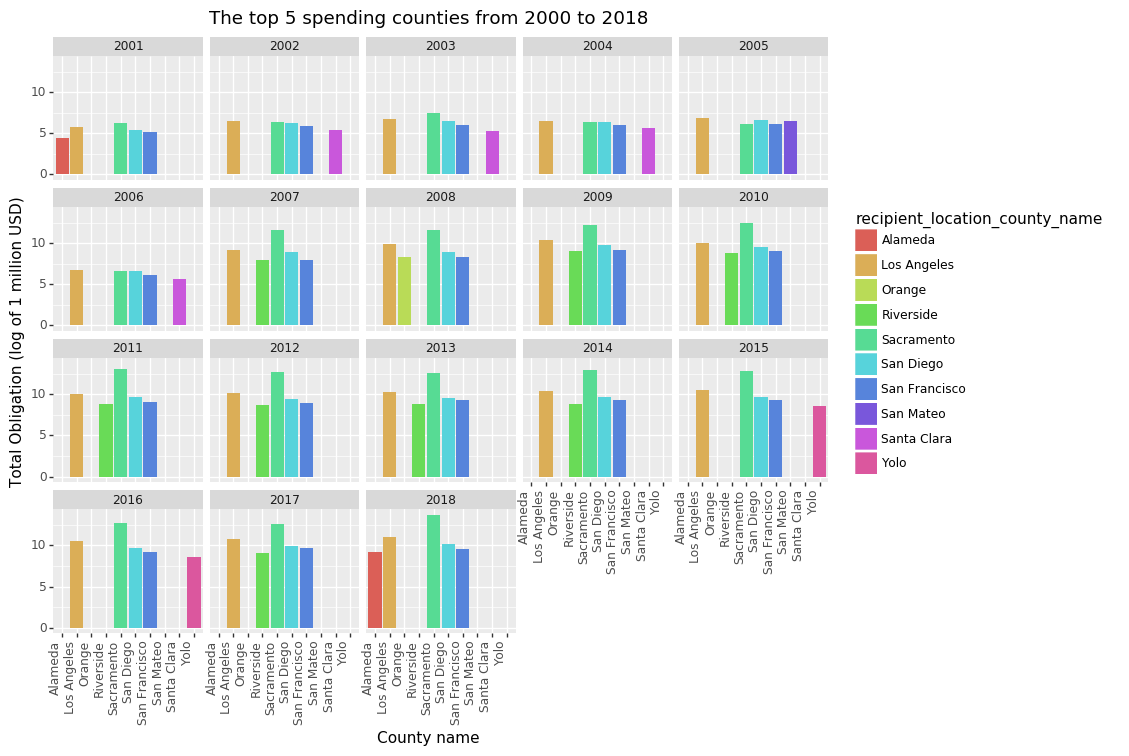

<ggplot: (-9223372029279882608)>

In [155]:
(
    p9.ggplot(aes(x='recipient_location_county_name', y='log_obligation', fill='recipient_location_county_name'), data = total_top_five) 
        + p9.geom_bar(stat='identity', position='dodge')
        + p9.facet_wrap('~fiscal_year)')
        + p9.labs(title='The top 5 spending counties from 2000 to 2018') 
        + p9.labels.ylab('Total Obligation (log of 1 million USD)')
        + p9.labels.xlab('County name')
        + p9.theme(axis_text_x = element_text(angle = 90, hjust = 1)) 
)


We can also see the amount funded/awarded to every county in California with this interactive map (unit: $1 million USD). Overall, over the years, the funding among every county has increased significantly, with Sacramento always being the top one.

In [94]:
counties_ca = {
    code: county for code, county in counties.items() if (county["state"] == "ca")
}

county_xs = [county["lons"] for county in counties_ca.values()]
county_ys = [county["lats"] for county in counties_ca.values()]
county_names = [county['name'] for county in counties_ca.values()]

def replace_nan(county_info):
    for l in county_info:
        for idx, item in enumerate(l):
            if np.isnan(item):
                l[idx] = np.nanmean(l)
    return(county_info)

county_xs = replace_nan(county_xs)
county_ys = replace_nan(county_ys)

In [95]:
sum_obligation = df.groupby(['fiscal_year','recipient_location_county_name'])['total_obligation'].sum().reset_index()
sum_obligation = sum_obligation[(sum_obligation['recipient_location_county_name']!= '') & (sum_obligation['fiscal_year']!= 2019)]

In [96]:
years = sum_obligation['fiscal_year'].unique()

for year in years:
    sub = sum_obligation[sum_obligation['fiscal_year']==year]
    temp = pd.DataFrame(columns=['fiscal_year', 'recipient_location_county_name', 'total_obligation'])
    for county in county_names:
        if county not in sub['recipient_location_county_name'].unique():
            temp = temp.append({'fiscal_year': year, 'recipient_location_county_name': county, 'total_obligation': 0}, ignore_index=True)
    for county in sub['recipient_location_county_name'].unique():
        if county not in county_names:
            sum_obligation = sum_obligation[sum_obligation['recipient_location_county_name']!= county]
    sum_obligation = sum_obligation.append(temp)
    

In [97]:
sum_obligation = sum_obligation.sort_values(by=['fiscal_year', 'recipient_location_county_name']).reset_index()

In [98]:
years = sum_obligation['fiscal_year'].unique()
data_list = []
for year in years:
    data = dict(
        x=county_xs,
        y=county_ys,
        name=county_names,
        year=str(year),
        rate=sum_obligation[sum_obligation['fiscal_year']==year]['total_obligation']
    )
    data_list.append(data)
plot_df = pd.DataFrame(data_list[0])
for i in range(1, len(data_list)):
    try:
        temp = pd.DataFrame(data_list[i])
        plot_df = plot_df.append(temp)
    except:
        print(i)

In [157]:
# Plotting with bokeh

data = ColumnDataSource(plot_df)
view = CDSView(source = data, filters = [GroupFilter(column_name = "year", group = "2001")])
color_mapper = LogColorMapper(palette="Viridis256", low=0, high=1e6)

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Department of Health and Human Services Funding in California from 2000-2018 (inflation-adjusted)", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    tooltips=[
        ("Name", "@name"), ("Spending)", "@rate"), ("(Long, Lat)", "($x, $y)")
    ])

p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=data, view = view,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

callback = CustomJS(args = {"source": data, "view": view}, code = """
    view.filters[0].group = cb_obj.value.toString();
    source.change.emit();
""")

slider = Slider(start=2001, end=2018, value=2001, title="Year")

slider.js_on_change("value", callback)


layout = Column(slider,p)
show(layout)

## B. What are the categories that receive the most money?

In [40]:
categories = df.groupby(['awarding_subtier_agency_name'])['total_obligation'].sum().reset_index().sort_values(by='total_obligation', ascending=False)

In [41]:
categories.head(10)

,awarding_subtier_agency_name,total_obligation
6,Centers for Medicare and Medicaid Services,4.207228e+06
0,Administration for Children and Families,8.068927e+05
21,Health Resources and Services Administration,3.995214e+05
24,National Institutes of Health,3.919327e+05
23,Indian Health Service,1.895652e+05
5,Centers for Disease Control and Prevention,5.441058e+04
10,Department of Energy,3.054296e+04
27,Office of Assistant Secretary for Preparedness...,2.479154e+04
36,Substance Abuse and Mental Health Services Adm...,2.079181e+04
22,Immediate Office of the Secretary,1.271531e+04


We can see that most of the money funded by Department of Health and Human Services goes to health category, such as Centers for Medicare and Medicaid Services, Health Resources and Services Administration, National Institutes of Health, Indian Health Service, and Centers for Disease Control and Prevention. Administration for Children and Families and Department of Energy are also the top agencies that receive the most money.

Does the medicare/medicaid funding change during different presidencies/political parties? To answer this question we can look at the funding for medicare/medicaid over the time.

In [172]:
medi = df[df['awarding_subtier_agency_name']=='Centers for Medicare and Medicaid Services'].groupby(['fiscal_year'])['total_obligation'].sum().reset_index().sort_values(by='fiscal_year', ascending=False)
presidents = ['Republican', 'Republican', 'Democrat', 'Democrat', 'Democrat', 'Democrat', 'Democrat', 'Democrat', 
              'Democrat', 'Democrat', 'Republican', 'Republican', 'Republican', 'Republican', 'Republican', 'Republican', 'Republican', 
              'Republican']
medi['President'] = presidents
medi['fiscal_year'] = medi['fiscal_year'].apply(lambda x: str(x))

In [173]:
medi

,fiscal_year,total_obligation,President
17,2018,894099.083733,Republican
16,2017,250620.624182,Republican
15,2016,312663.283014,Democrat
14,2015,358325.488743,Democrat
13,2014,408736.076484,Democrat
12,2013,259993.695077,Democrat
11,2012,306903.060395,Democrat
10,2011,445480.245339,Democrat
9,2010,220995.384827,Democrat
8,2009,202977.335385,Democrat


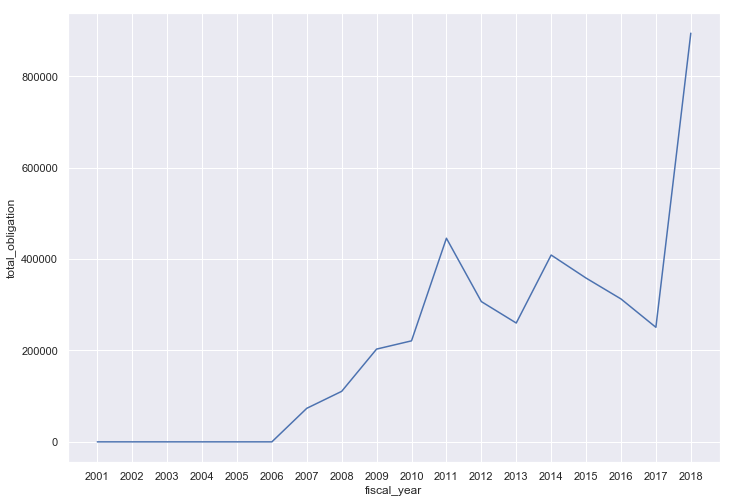

In [174]:
sns.lineplot(x='fiscal_year', y='total_obligation', data=medi)
plt.show()

## C. What's the correlation between the counties' population and demographics, and how they spend money?

To answer this question, we can look at [Census data in 2017](https://www.census.gov/quickfacts/ca) and compare it with how money was spent across county in 2017.


In [132]:
census = pd.read_csv('./aff_download/ACS_17_5YR_S0101_with_ann.csv')
labels = census.loc[0]

census = census.drop(census.index[[0]])

# Extract and convert useful columns to appropriate type

census.HC01_EST_VC37 = census.HC01_EST_VC37.astype(float).fillna(0.0)
census.HC03_EST_VC01 = census.HC03_EST_VC01.astype(float).fillna(0.0)
census.HC05_EST_VC01 = census.HC05_EST_VC01.astype(float).fillna(0.0)

census.HC01_EST_VC01 = census.HC01_EST_VC01.astype(float).fillna(0.0) # total pop

census.HC01_EST_VC03 = census.HC01_EST_VC03.astype(float).fillna(0.0) # total pop - under 5
census.HC02_EST_VC03 = census.HC02_EST_VC03.astype(float).fillna(0.0) # total percentage - under 5
census.HC01_EST_VC04 = census.HC01_EST_VC04.astype(float).fillna(0.0) # total pop - 5-9
census.HC02_EST_VC04 = census.HC02_EST_VC04.astype(float).fillna(0.0) # total percentage - 5-9
census.HC01_EST_VC05 = census.HC01_EST_VC05.astype(float).fillna(0.0) # total pop - 10-14
census.HC02_EST_VC05 = census.HC02_EST_VC05.astype(float).fillna(0.0) # total percentage - 10-14
census.HC01_EST_VC06 = census.HC01_EST_VC06.astype(float).fillna(0.0) # total pop - 15-19
census.HC02_EST_VC06 = census.HC02_EST_VC06.astype(float).fillna(0.0) # total percentage - 15-19

census.HC01_EST_VC15 = census.HC01_EST_VC15.astype(float).fillna(0.0) # 60-64
census.HC02_EST_VC15 = census.HC02_EST_VC15.astype(float).fillna(0.0)
census.HC01_EST_VC16 = census.HC01_EST_VC16.astype(float).fillna(0.0) # 65-69
census.HC02_EST_VC16 = census.HC02_EST_VC16.astype(float).fillna(0.0)
census.HC01_EST_VC17 = census.HC01_EST_VC17.astype(float).fillna(0.0) # 70-74
census.HC02_EST_VC17 = census.HC02_EST_VC17.astype(float).fillna(0.0)
census.HC01_EST_VC18 = census.HC01_EST_VC18.astype(float).fillna(0.0) # 75-79
census.HC02_EST_VC18 = census.HC02_EST_VC18.astype(float).fillna(0.0)
census.HC01_EST_VC19 = census.HC01_EST_VC19.astype(float).fillna(0.0) # 80-84
census.HC02_EST_VC19 = census.HC02_EST_VC19.astype(float).fillna(0.0)
census.HC01_EST_VC20 = census.HC01_EST_VC20.astype(float).fillna(0.0) # 85 and above
census.HC02_EST_VC20 = census.HC02_EST_VC20.astype(float).fillna(0.0)

# Calculate + rename 

census['HC01_EST_VC01'] = census['HC01_EST_VC01'] / 1000000

census['children_num'] = (census.HC01_EST_VC03 + census.HC01_EST_VC04 + census.HC01_EST_VC05 + census.HC01_EST_VC06) / 1000000
census['children_percentage'] = census.HC02_EST_VC03 + census.HC02_EST_VC04 + census.HC02_EST_VC05 + census.HC02_EST_VC06

census['elder_num'] = (census.HC01_EST_VC15 + census.HC01_EST_VC16 + census.HC01_EST_VC17 + census.HC01_EST_VC18 + census.HC01_EST_VC19 + census.HC01_EST_VC20) / 1000000
census['elder_percentage'] = census.HC02_EST_VC15 + census.HC02_EST_VC16 + census.HC02_EST_VC17 + census.HC02_EST_VC18 + census.HC02_EST_VC19 + census.HC02_EST_VC20

# Format county name in census data:
census['GEO.display-label'] = census['GEO.display-label'].apply(lambda name: name.replace(' County, California',''))

# Only extract what need from census data:
census_clean = census[['GEO.display-label', 'HC01_EST_VC37', 'HC03_EST_VC01', 'HC05_EST_VC01', 'HC01_EST_VC01','children_num', 'children_percentage', 'elder_num', 'elder_percentage']].copy()
census_clean.columns = ['county', 'median_age', 'male', 'female', 'total_population', 'children_num', 'children_percentage', 'elder_num', 'elder_percentage']

In [133]:
total_spending_in_2017 = df[df['fiscal_year'] == 2017].groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()

In [134]:
total_spending = total_spending_in_2017.merge(census_clean, left_on='recipient_location_county_name', right_on='county')

- **Population and obligation:**

There is a positive, but weak correlation (0.24) between the population of a county, and the amount of money it's funded/awarded. Sacremento is an outlier in the regression model.


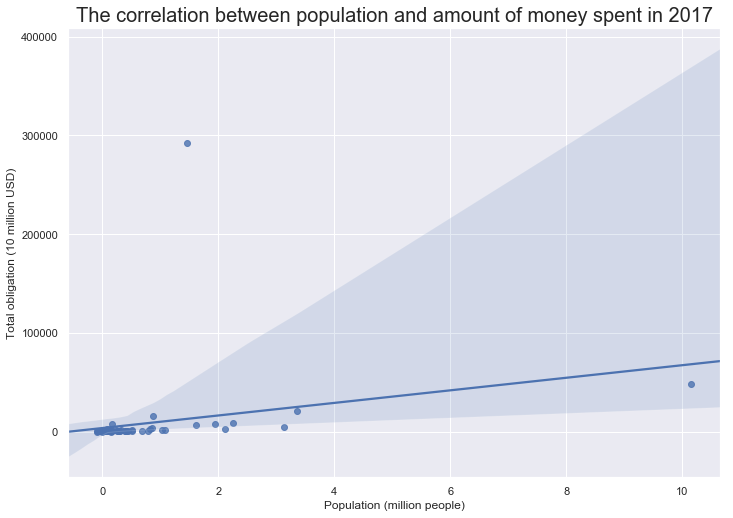

In [135]:
ax = sns.regplot(x="total_population", y="total_obligation", data=total_spending, x_jitter=.1)
ax.set_title('The correlation between population and amount of money spent in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

This may be because each (smaller) county would receive a base amount of award, which is not correlated to their population, and additional amount based on each unit of increasement in population. It also depends on the categories of the spending. We can investigate some categories in spending, to see which of them are more correlated to the population and the demographic of people living in that state.

**a. Health Resources and Services Administration**

In [48]:
health = df[(df['fiscal_year'] == 2017) & (df['awarding_subtier_agency_name'] == 'Health Resources and Services Administration')]
health_num = health.groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()
health_df = health_num.merge(census_clean, left_on='recipient_location_county_name', right_on='county')
health_df['special_num'] = health_df['children_num'] + health_df['elder_num']
health_df['money_spent_per_million_people'] = health_df['total_obligation'] / health_df['total_population']
health_df = health_df.sort_values(by='total_obligation', ascending=False)

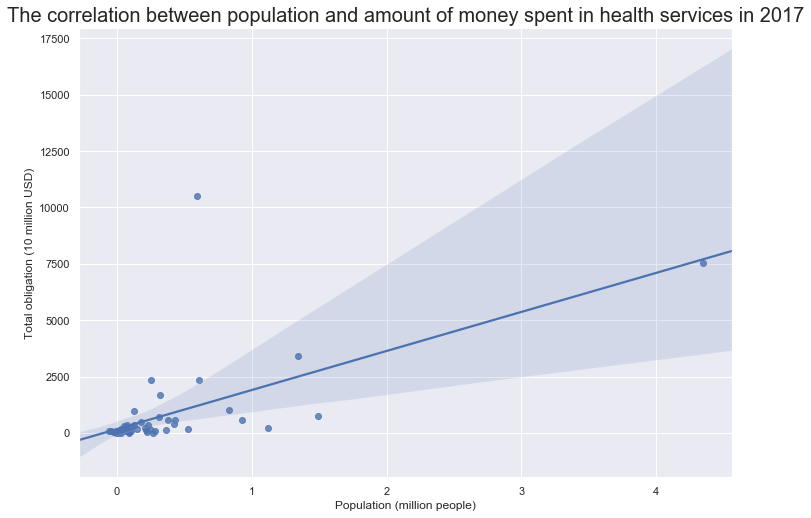

In [49]:
ax = sns.regplot(x="special_num", y="total_obligation", data=health_df, x_jitter=.1)
ax.set_title('The correlation between population and amount of money spent in health services in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

We can observe that the total population of one state and its amount of funding is more strongly correlated, being 0.63.

We can also look at the correlation between the number of children and elder in each counties, and its funding in health services. The plot of the number of children and elder vs the money spent has a similar shape to the last plot, indicates that the number of children and elder have as much as a similar effect to the funding as the total population. In other words, having more children and elder don't drive the funding in healthcare too much.

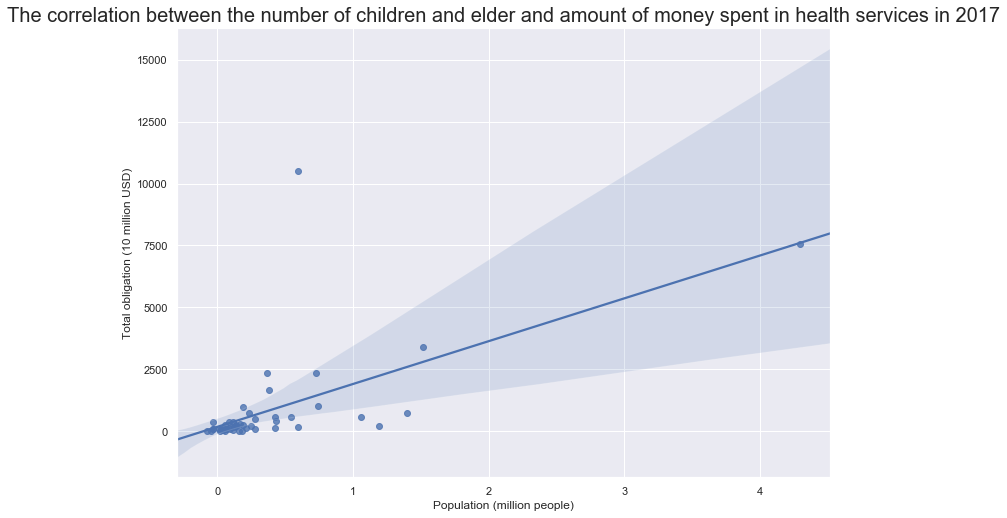

In [50]:
ax = sns.regplot(x="special_num", y="total_obligation", data=health_df, x_jitter=.1)
ax.set_title('The correlation between the number of children and elder and amount of money spent in health services in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

**b. Substance Abuse and Mental Health Services Administration**

In [54]:
substance = df[(df['fiscal_year'] == 2017) & (df['awarding_subtier_agency_name'] == 'Substance Abuse and Mental Health Services Administration')]
substance_num = substance.groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()
substance_df = substance_num.merge(census_clean, left_on='recipient_location_county_name', right_on='county')
substance_df['money_spent_per_ten_million_people'] = substance_df['total_obligation'] / substance_df['total_population']
substance_df = substance_df.sort_values(by='money_spent_per_ten_million_people', ascending=False)

In [55]:
substance_corr = substance_df['median_age'].corr(substance_df['total_obligation'])

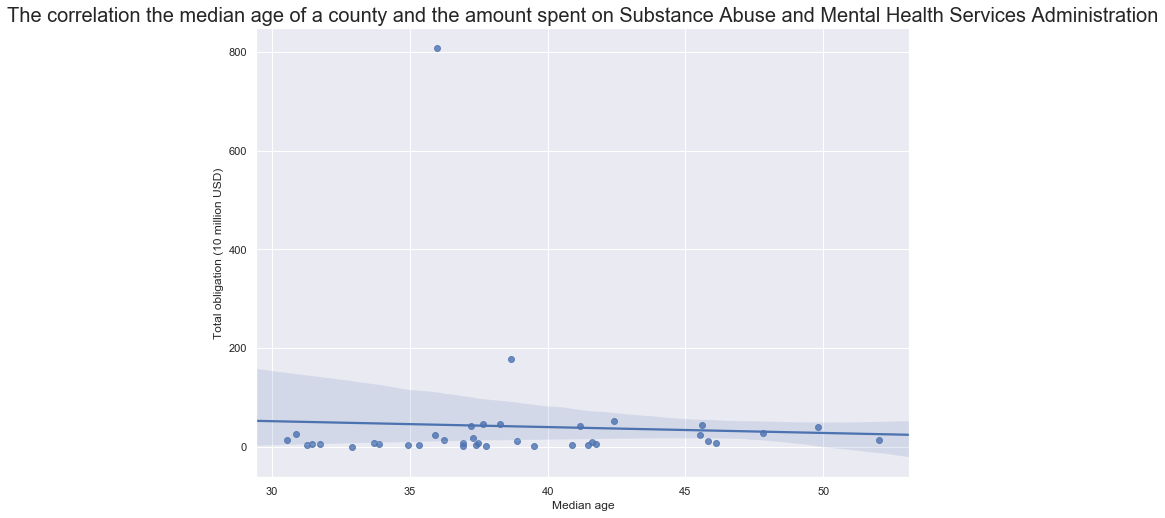

In [56]:
ax = sns.regplot(x="median_age", y="money_spent_per_ten_million_people", data=substance_df, x_jitter=.1)
ax.set_title('The correlation the median age of a county and the amount spent on Substance Abuse and Mental Health Services Administration', fontsize=20)
ax.set_xlabel('Median age')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

There is a weak negative correlation between the median age of the people who live in the county, and the amount of funding that the county has on Substance Abuse and Mental Health Service. As the population gets older, the amount that the county has to spend on Substance Abuse and Mental Health Service slightly decrease.